## Data preprocessing

##### Copyright (C) Microsoft Corporation.  
see license file for details

In [23]:
# Allow multiple displays per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [24]:
# AZUREML_NATIVE_SHARE_DIRECTORY mapping to host dir is set by _nativeSharedDirectory_ in .compute file 

import os
try:
    amlWBSharedDir = os.environ['AZUREML_NATIVE_SHARE_DIRECTORY']    
except:
    amlWBSharedDir = ''
    print('not using aml services?')
    
amlWBSharedDir

'/azureml-share/'

In [25]:
# # Use the Azure Machine Learning data collector to log various metrics
# from azureml.logging import get_azureml_logger
# logger = get_azureml_logger()

In [26]:
# Use Azure Machine Learning history magic to control history collection
# History is off by default, options are "on", "off", or "show"
# %azureml history on

In [27]:
# import utlity functions

import sys, os
paths_to_append = [os.path.join(os.getcwd(), os.path.join(*(['Code',  'src'])))]
def add_path_to_sys_path(path_to_append):
    if not (any(path_to_append in paths for paths in sys.path)):
        sys.path.append(path_to_append)

[add_path_to_sys_path(crt_path) for crt_path in paths_to_append]

import trvis_utils, image_featurization

[None]

In [28]:
#### Path variables

In [29]:
prj_consts = trvis_utils.trvis_consts()
data_base_input_dir=os.path.join(amlWBSharedDir, os.path.join(*(prj_consts.BASE_INPUT_DIR_list)))
data_dir = os.path.join(data_base_input_dir, os.path.join(*(['cats_and_dogs', 'train'])))
output_dir = os.path.join(data_base_input_dir, os.path.join(*(prj_consts.PROCESSED_DATA_DIR_list))) 
pretrained_models_dir = os.path.join(data_base_input_dir, os.path.join(*(prj_consts.PRETRAINED_MODELS_DIR_list))) 
os.makedirs(pretrained_models_dir, mode=0o777, exist_ok=True)
pretrained_models_dir
os.listdir(pretrained_models_dir)

os.makedirs(output_dir, mode=0o777, exist_ok=True)
output_dir

'/azureml-share/data/models/pretrained'

['DenseNetImageNet121.h5',
 'DenseNetImageNet121_activation_121.h5',
 'ResNet50_.h5',
 'DenseNetImageNet121_.h5',
 'ResNet50.h5']

'/azureml-share/data/processed'

In [30]:
from keras.applications.resnet50 import ResNet50
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import random


from keras.layers import Dense
from keras.models import Model
from keras.models import load_model
from keras_contrib.applications.densenet import DenseNetImageNet121
from keras.layers import GlobalAveragePooling2D

import keras_contrib

In [31]:
RECOMPUTE=False
SAMPLE_DATA = False
    
# densenet layers
# name          size    connected_to
# dense_2_3_bn  1408    concatenate_311
# dense_2_8_bn  2048    concatenate_316 
# dense_2_10_bn 2304    concatenate_318  
    
# model_name_list = [ResNet50]
# model_layer_list = ['']
# model_name_list = [ResNet50, DenseNetImageNet121, DenseNetImageNet121, DenseNetImageNet121, DenseNetImageNet121]
# model_layer_list = ['','dense_2_3_bn', 'dense_2_8_bn', 'dense_2_10_bn', '']   

# model_name_list = [DenseNetImageNet121, DenseNetImageNet121, DenseNetImageNet121]
# # model_layer_list = ['','concatenate_58', 'concatenate_56', 'concatenate_50']
# model_layer_list = ['activation_121','final_bn', 'dense_3_15_conv2D']

# model_name_list = [DenseNetImageNet121]
# model_layer_list = ['activation_121']

model_name_list = [ResNet50, DenseNetImageNet121]
model_layer_list = ['', 'activation_121']



sample_size = 400
saved_data_file_appendix = ''
if SAMPLE_DATA:
    saved_data_file_appendix = '_sample'


In [32]:
%matplotlib inline

import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt

In [33]:
training_image_files = os.listdir(data_dir)

if SAMPLE_DATA:
    training_image_files= random.sample(training_image_files, sample_size)

len(training_image_files)
training_image_files[:2]
image_file_names = list(os.path.join(data_dir, fname) for fname in training_image_files)
image_file_names[:2]

25000

['dog.6858.jpg', 'dog.1106.jpg']

['/azureml-share/data/cats_and_dogs/train/dog.6858.jpg',
 '/azureml-share/data/cats_and_dogs/train/dog.1106.jpg']

In [34]:
os.listdir(output_dir)

['features_DenseNetImageNet121_sampleactivation_121tsne.npy',
 'labels_.npy',
 'features_DenseNetImageNet121activation_121tsne.npy',
 'features_ResNet50tsne.npy',
 'labels__sample.npy',
 'features_ResNet50.npy',
 'features_DenseNetImageNet121_sampleactivation_121.npy',
 'features_DenseNetImageNet121activation_121.npy']

In [35]:
!ls ~/.keras/models/

ls: cannot access '/home/mmlspark/.keras/models/': No such file or directory


In [36]:
class pretrained_model:
   
    def set_model(self, DL_model, DL_model_name, base_model_dir = pretrained_models_dir):
        self.name = DL_model_name
        self.model = DL_model
        self.base_model_dir = base_model_dir

    def __init__(self, DL_architecture = None, intermediate_layer = '', base_model_dir = pretrained_models_dir):
        if DL_architecture is None:
            pass
        else:
            self.name = DL_architecture.__name__
           
            base_model_file_name = os.path.join(base_model_dir, DL_architecture.__name__+'.h5') 
            if os.path.isfile( base_model_file_name ):
                print(' - '+DL_architecture.__name__ + ' model: Base model ' + base_model_file_name + ' found!')
                crt_base_model = load_model(base_model_file_name)
            else:
                crt_base_model = DL_architecture(input_shape=(224, 224, 3),
                                             weights='imagenet',
                                             include_top=False)
                crt_base_model.save(base_model_file_name)
            
#             print(crt_base_model.summary())
            if not (intermediate_layer==''):
                crt_model = Model(inputs=crt_base_model.input, outputs=crt_base_model.get_layer(intermediate_layer).output)
                print(' - '+DL_architecture.__name__ + ' model: selected layer '+ intermediate_layer + '!')
            else:
                crt_model = crt_base_model
            
            if DL_architecture.__name__.startswith('DenseNet'):
                x = crt_model.output
                tl_features = GlobalAveragePooling2D(name='GAP_pool')(x)
                crt_model = Model(inputs=crt_model.input, outputs=tl_features)
                print(' - '+DL_architecture.__name__ + ' model: added GAP layer')
                
            print(crt_model.summary())            
            self.model = crt_model

def pretrained_models_generator(model_name_list):
    """Yield successive pretrained models."""
    for crt_model_name in model_name_list: 
        yield pretrained_model(crt_model_name)

def get_keras_pretrained_model(architecture_name, last_layer_name, model_dir = pretrained_models_dir):
    crt_model_file_name = os.path.join(model_dir, architecture_name.__name__+'_'+last_layer_name+'.h5') 
    if os.path.isfile( crt_model_file_name ):
        print('Model ' + crt_model_file_name + ' found!')
        crt_model = pretrained_model()
        crt_model.set_model(load_model(crt_model_file_name), architecture_name.__name__)
    else:
        crt_model = pretrained_model(architecture_name, last_layer_name)
        crt_model.model.save(crt_model_file_name)
    return(crt_model)        
        
# crt_pretrained_models = [pretrained_model(ResNet50), pretrained_model(DenseNetImageNet121)]
# print(crt_model.name for crt_model in crt_pretrained_models)
# models = dict([ (m.name, m.model) for m in crt_pretrained_models ])

In [37]:
somemodel = get_keras_pretrained_model(DenseNetImageNet121, '').model
somemodel.summary()
del somemodel

Model /azureml-share/data/models/pretrained/DenseNetImageNet121_.h5 found!
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
initial_conv2D (Conv2D)         (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
initial_bn (BatchNormalization) (None, 112, 112, 64) 256         initial_conv2D[0][0]             
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           initial_bn[0][0]                 
__________________________________

In [38]:
# model_layer_list = ['concatenate_290', 'concatenate_280', 'concatenate_260', 'concatenate_240']
# model_layer_list[0]
# crt_model1 = Model(inputs=somemodel.input, outputs=somemodel.get_layer(model_layer_list[0]).output)

In [39]:
def featurize_images_multiple_models(crt_image_file_names, output_dir, model_name_list, model_layer_list, batch_size=8):
    for crt_model_name, crt_model_layer in zip(model_name_list, model_layer_list):
        print('processing model ' + crt_model_name.__name__+' layer '+crt_model_layer)
        features_filename = os.path.join(output_dir, 'features_' +\
                                         crt_model_name.__name__+saved_data_file_appendix+\
                                         crt_model_layer+'.npy')
        if os.path.isfile(features_filename) and RECOMPUTE is False:
            print("Features found!")
        else:
            print("Computing features")
#             crt_model = pretrained_model(crt_model_name, crt_model_layer).model
            crt_model = get_keras_pretrained_model(crt_model_name, crt_model_layer).model
            features = image_featurization.featurize_images(crt_image_file_names, crt_model, batch_size) 
            print(features.shape)
            np.save(features_filename, features)
            del crt_model
            del features

featurize_images_multiple_models(image_file_names, output_dir, model_name_list, model_layer_list)            

processing model ResNet50 layer 
Features found!
processing model DenseNetImageNet121 layer activation_121
Features found!


In [40]:
# model_name_list = [DenseNetImageNet121]

In [41]:
def apply_tsne_to_multiple_features(output_dir, crt_model_name_list, model_layer_list):
    for crt_model_name, crt_model_layer in zip(model_name_list, model_layer_list):
        print('tsne processing for model ' + crt_model_name.__name__+' layer '+crt_model_layer)
        tsne_features_filename = os.path.join(output_dir, 'features_' + \
                                              crt_model_name.__name__+saved_data_file_appendix+\
                                              crt_model_layer+'tsne.npy')
        if os.path.isfile(tsne_features_filename) and RECOMPUTE is False:
            print("tsne features found!")
        else:
            print("Computing tsne features")
            original_features = np.load(os.path.join(output_dir, 'features_' + \
                                                     crt_model_name.__name__+saved_data_file_appendix+\
                                                     crt_model_layer+'.npy'))
            print(original_features.shape)
            original_features = original_features.reshape(original_features.shape[0], -1)
            print(original_features.shape)
            images_tsne = TSNE(n_components=2, random_state=0).fit_transform(original_features)
            print(images_tsne.shape)
            np.save(tsne_features_filename, images_tsne)
            del images_tsne
            del original_features
apply_tsne_to_multiple_features(output_dir, model_name_list, model_layer_list)                        

tsne processing for model ResNet50 layer 
tsne features found!
tsne processing for model DenseNetImageNet121 layer activation_121
tsne features found!


In [42]:
labels_filename = os.path.join(output_dir, 'labels_' + \
                                              saved_data_file_appendix+\
                                              '.npy')
if os.path.isfile(labels_filename) and RECOMPUTE is False:
    print('Label file '+labels_filename+' found!')
    y = np.load(labels_filename)
else:
  y = pd.Series(training_image_files).str.contains('cat').astype(int).values
  np.save(labels_filename, y)

print(y.shape)
print(y[y==0].shape)
print(y[y==1].shape)


Label file /azureml-share/data/processed/labels_.npy found!
(25000,)
(12500,)
(12500,)


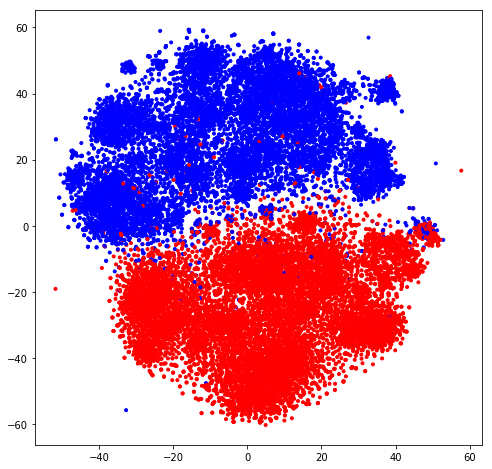

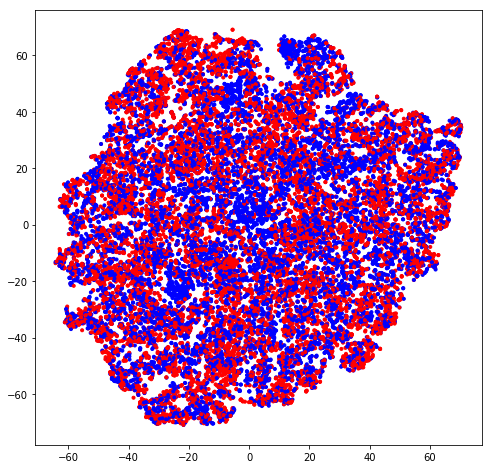

In [43]:
cat_labels = y == 0
dog_labels = y == 1
def visualize_tsne_features(crt_model_name_list, model_layer_list):
    for crt_model_name, crt_model_layer in zip(model_name_list, model_layer_list):
        tsne_features_filename = os.path.join(output_dir, 'features_' + \
                                              crt_model_name.__name__+saved_data_file_appendix+\
                                              crt_model_layer+'tsne.npy')
        tsne_features = np.load(tsne_features_filename)
        plt.figure(figsize=(8, 8))
        plt.scatter(x = tsne_features[:,0], y=tsne_features[:,1], marker=".", c=y, cmap=plt.cm.get_cmap('bwr'))

        plt.show()
        
visualize_tsne_features(model_name_list, model_layer_list)      

In [44]:
# jupyter nbconvert --to html .\Code\02_Model\020_visualize_class_separability.ipynb